In [1]:
import keras
from keras.layers import Input, Dense
from keras.models import Model
from keras.regularizers import l1
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import sys
import h5py
import pandas as pd
sys.path.insert(0,'../lib')
from evaluation import makeRoc, learningCurveLoss

Using TensorFlow backend.


In [9]:
l1Reg = 0.0001
Inputs = Input(shape=(16,))
x = Dense(64, activation='relu', kernel_initializer='lecun_uniform', name='fc1_relu', kernel_regularizer=l1(l1Reg))(Inputs)
x = Dense(32, activation='relu', kernel_initializer='lecun_uniform', name='fc2_relu', kernel_regularizer=l1(l1Reg))(x)
x = Dense(32, activation='relu', kernel_initializer='lecun_uniform', name='fc3_relu', kernel_regularizer=l1(l1Reg))(x)
predictions = Dense(5, activation='softmax', kernel_initializer='lecun_uniform', name = 'output_softmax', 
                    kernel_regularizer=l1(l1Reg))(x)
model = Model(inputs=Inputs, outputs=predictions)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 16)]              0         
_________________________________________________________________
fc1_relu (Dense)             (None, 64)                1088      
_________________________________________________________________
fc2_relu (Dense)             (None, 32)                2080      
_________________________________________________________________
fc3_relu (Dense)             (None, 32)                1056      
_________________________________________________________________
output_softmax (Dense)       (None, 5)                 165       
Total params: 4,389
Trainable params: 4,389
Non-trainable params: 0
_________________________________________________________________


In [3]:
f = h5py.File('../processed-pythia82-lhc13-all-pt1-50k-r1_h022_e0175_t220_nonu_withPars_truth_0.z', 'r')
treeArray = f['t_allpar_new'][()]

features = ['j_zlogz', 'j_c1_b0_mmdt', 'j_c1_b1_mmdt', 'j_c1_b2_mmdt', 'j_c2_b1_mmdt', 'j_c2_b2_mmdt', 
            'j_d2_b1_mmdt', 'j_d2_b2_mmdt', 'j_d2_a1_b1_mmdt', 'j_d2_a1_b2_mmdt', 
            'j_m2_b1_mmdt', 'j_m2_b2_mmdt', 'j_n2_b1_mmdt', 'j_n2_b2_mmdt', 'j_mass_mmdt', 'j_multiplicity']
labels = ['j_q', 'j_g', 'j_w', 'j_z', 'j_t']

features_labels_df = pd.DataFrame(treeArray,columns=list(set(features+labels)))
features_labels_df = features_labels_df.drop_duplicates()

features_val = features_labels_df[features].values #Convert to numpy array
labels_val = features_labels_df[labels].values

In [4]:
X_train, X_test, y_train, y_test = train_test_split(features_val, labels_val, test_size=0.2, random_state=42)

## Training

In [5]:
adam = Adam(lr=0.0001)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])

In [6]:
history = model.fit(X_train, y_train, batch_size = 1024, epochs = 100, 
                    validation_split = 0.25, shuffle = True, callbacks = None,
                    use_multiprocessing=True, workers=4)

Epoch 1/100
58/58 [==============================] - 0s 6ms/step - loss: 1.3232 - accuracy: 0.1382 - val_loss: 0.9407 - val_accuracy: 0.2588
Epoch 2/100
58/58 [==============================] - 0s 4ms/step - loss: 0.7355 - accuracy: 0.3068 - val_loss: 0.5871 - val_accuracy: 0.3356
Epoch 3/100
58/58 [==============================] - 0s 4ms/step - loss: 0.5346 - accuracy: 0.3417 - val_loss: 0.5111 - val_accuracy: 0.3470
Epoch 4/100
58/58 [==============================] - 0s 4ms/step - loss: 0.5069 - accuracy: 0.3570 - val_loss: 0.5022 - val_accuracy: 0.3640
Epoch 5/100
58/58 [==============================] - 0s 4ms/step - loss: 0.5000 - accuracy: 0.3678 - val_loss: 0.4965 - val_accuracy: 0.3720
Epoch 6/100
58/58 [==============================] - 0s 4ms/step - loss: 0.4949 - accuracy: 0.3801 - val_loss: 0.4919 - val_accuracy: 0.3883
Epoch 7/100
58/58 [==============================] - 0s 4ms/step - loss: 0.4903 - accuracy: 0.3902 - val_loss: 0.4876 - val_accuracy: 0.3879
Epoch 8/100
5

## Validation

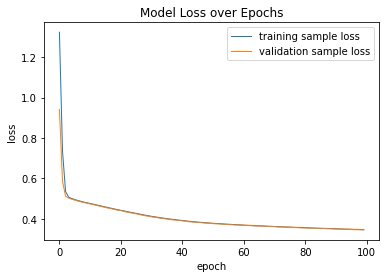

In [7]:
learningCurveLoss(history)

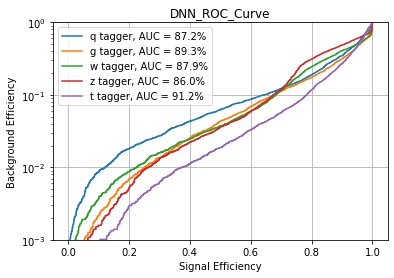

In [8]:
y_pred = makeRoc(X_test, y_test, labels, model, outputSuffix='DNN')